# ZMS LAB 043 - case GWINTEX

kontakt: annaszczurek2@gmail.com


## Opis zajęć


Firma GWINTEX S.A. jest międzynarodowym potentatem w dziedzinie produkcji korkociągów. Korkociągi są wytwarzane na bardzo nowoczesnych maszynach metalurgicznych. W związku ze znacznym wzrostem zamówień firma planuje uruchomienie nowej hali produkcyjnej, w której znajdzie się **n=6 maszyn**. Do każdej maszyny jest przypisany operator, który jest odpowiedzialny za jej obsługę oraz usuwanie awarii. Na podstawie pomiarów historycznych wiadomo, że **czas bezawaryjnej pracy maszyny ma rozkład wykładniczy ze średnią 75 minut**. W przypadku wystąpienia awarii operator dzwoni do warsztatu z prośbą o dostarczenie pakietu narzędzi naprawczych. Pakiet narzędzi jest bardzo ciężki i w związku z tym musi być transportowany za pomocą przenośnika taśmowego (taśmociągu). **Czas transportu zestawu narzędzi do maszyny wynosi *ti*, i=1..6. Czas naprawy jest zmienną losową z rozkładu Erlanga k=3 i średnio wynosi 15 minut**. Po ukończeniu naprawy narzędzia są powtórnie umieszczane na taśmociągu i wracają w komplecie do warsztatu celem ich uzupełnienia. Ze względu na specyfikę specjalistycznych narzędzi nie jest możliwe dokonywanie kolejnych napraw przed powrotem narzędzi do warsztatu. Ze względu na bardzo wysoką cenę jednego pakietu narzędzi naprawczych ich liczba ***m* jest mniejsza od liczby maszyn w hali produkcyjnej**. Gdy w danej chwili pakiet narzędzi nie jest dostępny operator czeka aż inny pakiet wróci do warsztatu i zostanie mu wysłany.

Zarząd firmy GWINTEX zastanawia się **jakie powinno być rozmieszczenie urządzeń na hali produkcyjnej** oraz **ile pakietów narzędziowych do obsługi maszyn należy zakupić**. Rozważane są dwie organizacje hali produkcyjnej – układ liniowy oraz układ gniazdowy. **W układzie liniowym czas transportu narzędzi z warsztatu do maszyny wynosi ***ti=i*2***, natomiast **w układzie gniazdowym czas ten jest stały i wynosi 3 minuty**. Czas transportu narzędzi do warsztatu jest taki sam jak czas transportu do maszyny. Wprowadzenie układu gniazdowego wiąże się z wyższymi kosztami instalacyjnymi związanymi z uruchomieniem sześciu niezależnych taśmociągów.




## ROZWIĄZANIE

*author: P*

### 1. Stałe i zmienne wykorzystane w modelu

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# ilość zestawów narzędzi
m = 2

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 1000   

In [29]:
# Toolset transport times for all considered setups - this should facilitate easier handling of new
# setups
transport_times = {'L': {i:2*(i+1) for i in range(6)}, 'G': {i:3 for i in range(6)},
                   'L2': {0:6, 1:4, 2:2, 3:2, 4:4, 5:6}}

### 2. Model

Wektory, które mają za zadanie kontrolować stan symulacji:

- momenty wystąpienia kolejnych zdarzeń
- status narzędzi i maszyn 
    - `W` - pracuje 
    - `Q` - czeka na narzedzia 
    - `R` - jest naprawiona
- czas ich bezczynności
- events --> wektor zdarzeń, które zmieniają stan symulacji (np. zepsucie się maszyny, czas naprawy, itp.)

In [5]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji- najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machine = events.index(t)
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                transport_time = transport_times[setup][machine]
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] += repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            status[machine] = "R"
            transport_time = transport_times[setup][machine]
            repair_time = np.random.gamma(3, avg_repair_time/3)
            events[machine] += repair_time + transport_time
            tools_loc[tools] = machine
            tools_occupied[tools] += repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    # wynik - liste skumulowanych bezczynnosci dla kazdej z maszyn
    return (t_cum)

### 3. Funkcja do uruchomienia symulacji

Added seed to provide reproducibility of results

In [6]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup):
    avg_t_cum = []
    for i in range (iterations):
        np.random.seed(i)
        avg_t_cum.append(model( horizon, avg_working_time, avg_repair_time, n, m, setup))
    return list(map(np.mean, np.transpose(avg_t_cum)))


### 3. Symulacja

In [93]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[8001.949217385863,
 8796.153309349273,
 9429.426298458107,
 10122.496238521537,
 10858.20038289117,
 11468.16735891064]

In [8]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[7963.7787671263422,
 8726.912115948162,
 9451.1463341973431,
 10127.195944205723,
 10778.285911584057,
 11453.647507362011]

In [18]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "G")

[8313.5019853223403,
 8287.4807087069039,
 8525.7107725203095,
 8654.0727393056532,
 8425.2484168141636,
 8483.1339937925459]

In [21]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L2")

[9425.0862005853669,
 8776.1980700145123,
 8018.6077757133562,
 8340.5776848787864,
 8561.0899056974868,
 9440.1565673060777]

### 4. Simplest comparison

In [12]:
import time

In [13]:
t0 = time.clock()
results = {}
for setup in ['L', 'G', 'L2']:
    for m in range(5):
        results[(setup, m+1)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m+1, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

KeyboardInterrupt: 

In [13]:
df = pd.DataFrame.from_dict(results).T

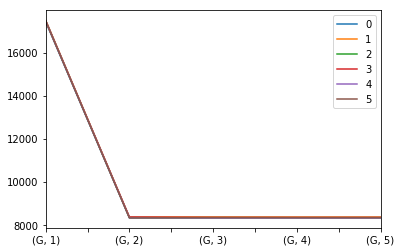

In [15]:
df.loc[('G', slice(None)),:].plot()

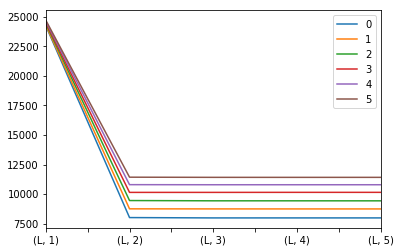

In [16]:
df.loc[('L', slice(None)),:].plot()

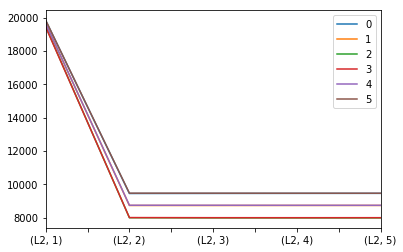

In [17]:
df.loc[('L2', slice(None)),:].plot()

Interestingly, either the simulation code contains some mistakes or buying more than 2 toolkits doesn't materially improve the efficiency.

In [19]:
df2 = df.mean(axis=1).unstack()

Basing on the table above we can approximate various intervals of machine downtime cost at which each solution would be optimal

In [20]:
df2 

,1,2,3,4,5
G,17464.526793,8360.691080,8357.604714,8357.481145,8357.481145
L,24467.989674,9770.147599,9757.190036,9757.330314,9757.089707
L2,19641.057846,8724.301445,8721.910920,8721.458366,8722.070405


In [23]:
df2.loc["L2",:] / df2.loc['L',:]

1    0.802725
2    0.892955
3    0.893896
4    0.893837
5    0.893921
dtype: float64

First observation is that for the initial parametrization, the proposed rearrangement of the linear setup provides at least 10% less machine downtime on average.

In [29]:
df2.loc[:,2:5].values / df2.loc[:,1:4].values

array([[ 0.47872417,  0.99963085,  0.99998521,  1.        ],
       [ 0.39930324,  0.99867376,  1.00001438,  0.99997534],
       [ 0.44418694,  0.99972599,  0.99994811,  1.00007018]])

The table above shows that while buying a second toolkit reduces machine downtime by more than 50%, purchasing more toolkits has almost no impact on total downtime. This will be most likely dependent on average time between failures as well as average repair time - do we want to analyse this relationship?

In [39]:
(df2.loc[:,1].values - df2.loc[:,2].values) / 60

array([ 151.73059523,  244.96403459,  181.94594001])

In [41]:
(df2.loc['L':'L2',2].values - df2.loc['G',2]) / 60

array([ 23.49094198,   6.06017276])

<b>Key findings:</b>
- In the current setting, a most-likely optimal scenario would be to purchase 2 toolkits.
- Notably, buying a second toolkit is much more important than changing the setup from linear to spherical/radial (or whatever the proper English name would be). This pays off as long as the cost of a single toolkit is no higher than 245 hours of monthly downtime per machine (181 hours if the modified linear setup can be accommodated).
- Any further improvement would require implementing radial setup instead of the linear one. This is reasonable when the extra cost of implementing this setup doesn't exceed the costs associated with an average of 23.5 hours of downtime per machine (6 if the modified linear setup is feasible).
- Thus, if machine downtime costs is moderate, the recommended solution is to implement the modified linear setup and purchase 2 toolkits. Profits from any further investments will be negligible, unless the cost difference between the spherical and the linear setup is also small.</li>
<br><b>TBA: sensitivity analysis (suggested variables: average time between failures, average repair time, perhaps variance of the repair time)</b>

<b>Issues:</b>
- Since df2.loc['G',4] == df2.loc['G',5] should we be worried about proper seed setting?

<b>Data export</b><br>
<i>So that it is not necessary to run the simulation over and over again to modify a few plots</i>

In [43]:
df.to_hdf('results.hdf', key = 'full_results')
df2.to_hdf('results.hdf', key = 'machine_means')

In [45]:
# Check
if df.equals(pd.read_hdf('results.hdf', key = 'full_results')):
    if df2.equals(pd.read_hdf('results.hdf', key = 'machine_means')):
        print('All DataFrames saved correctly')
    else:
        print('df2 saved/read incorrectly')
else: print('df saved/read incorrectly')

All DataFrames saved correctly


### 5. Some more sensitivity analysis

I assume we use 2 sets of toolkits in all setups

In [32]:
t0 = time.clock()
results_rapair = {}
for setup in ['L', 'G', 'L2']:
    for rapair_improvement in range(5):
        results_rapair[(setup, rapair_improvement)] = run_model(iterations, horizon, avg_working_time, avg_repair_time - rapair_improvement, n, m, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

Entire simulation duration time: 44.8s


In [39]:
pd.DataFrame.from_dict(results_rapair)

L                                                          \
              0             1             2             3             4   
0   8001.949217   7620.327564   7195.449715   6806.792362   6430.555044   
1   8796.153309   8300.064339   8015.813954   7593.579572   7214.479585   
2   9429.426298   9156.306441   8754.660856   8345.122279   8031.080129   
3  10122.496239   9718.917226   9507.268559   9090.442683   8792.687025   
4  10858.200383  10548.660268  10100.275201   9827.588052   9441.773686   
5  11468.167359  11117.394016  10827.446973  10520.661282  10246.005135   

             G                                                      \
             0            1            2            3            4   
0  8344.349189  8011.920374  7630.334579  7212.224833  6821.216144   
1  8359.205767  7956.281637  7590.533819  7203.515048  6835.753428   
2  8344.289224  8017.680442  7586.875301  7188.169512  6859.836096   
3  8316.062734  7973.071988  7612.724946  7212.762418  6829.725947   
4  8321.934945  7928.111189  7625.579735  7174.040950  6787.012171   
5  8323.318135  7968.294927  7633.003826  7224.225296  6777.819732   

            L2                                                      
             0            1            2            3            4  
0  9469.118198  9101.481141  8750.219322  8351.104410  7982.064575  
1  8660.669214  8349.317548  7966.440246  7592.298523  7206.823592  
2  7975.432277  7593.969298  7198.739616  6828.505158  6396.271592  
3  8059.417747  7535.188244  7190.496495  6833.843631  6394.605233  
4  8782.494430  8397.074366  8059.201949  7590.709673  7205.080759  
5  9462.369773  9138.977207  8705.028204  8413.597858  7961.352013

In [33]:
df_repair = pd.DataFrame.from_dict(results_rapair).T

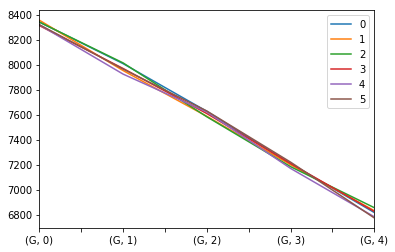

In [34]:
df_repair.loc[('G', slice(None)),:].plot()

Changes in cumulative time while reducing rapiar time by addisional minute

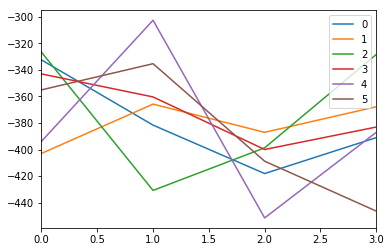

In [62]:
pd.DataFrame(df_repair.loc['G'].iloc[1:,:].values - df_repair.loc['G'].iloc[:4,:].values).plot()

In [71]:
np.mean(df_repair.loc['G'].iloc[1:,:].values - df_repair.loc['G'].iloc[:4,:].values)/60

-6.31791421904489

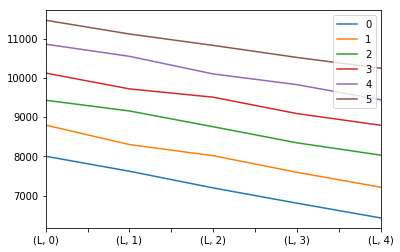

In [35]:
df_repair.loc[('L', slice(None)),:].plot()

Marginal changes

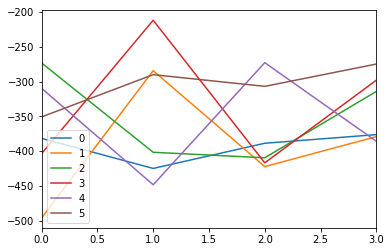

In [63]:
pd.DataFrame(df_repair.loc['L'].iloc[1:,:].values - df_repair.loc['L'].iloc[:4,:].values).plot()

In [70]:
np.mean(df_repair.loc['L'].iloc[1:,:].values - df_repair.loc['L'].iloc[:4,:].values)/60

-5.916536250525178

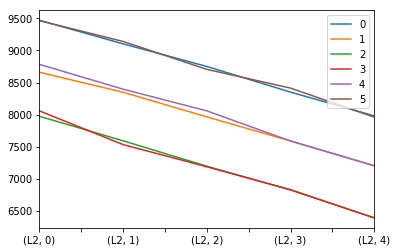

In [36]:
df_repair.loc[('L2', slice(None)),:].plot()

Marginal changes

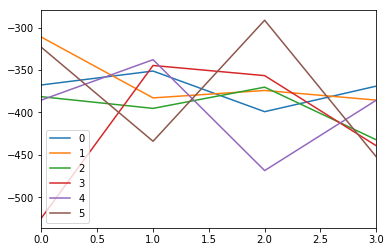

In [64]:
pd.DataFrame(df_repair.loc['L2'].iloc[1:,:].values - df_repair.loc['L2'].iloc[:4,:].values).plot()

In [69]:
np.mean(df_repair.loc['L2'].iloc[1:,:].values - df_repair.loc['L2'].iloc[:4,:].values)/60

-6.432849912349217

It's worth considering extra trainings for workers to make process of repairs faster. As long as it costs of training of one worker to reduce time of repair by 1 minut aren't higher than cost of about 6,4 hours for "L2", 6,3 for "G and 5,9 for "L" it's worth investing as the profits from time reduction seems to be linear

In [72]:
# saving results
df_repair.to_hdf('results_repiar.hdf', key = 'full_results')

In [75]:
# Check
if df_repair.equals(pd.read_hdf('results_repiar.hdf', key = 'full_results')):
    print('All DataFrames saved correctly')
else: 
    print('df saved/read incorrectly')

All DataFrames saved correctly


#### Another analysis

Assuming one toolkit and bad times for company when it needs to reduce production, will it be better to have have "G", "L" or "L2"

In [162]:
t0 = time.clock()
results_machine_reduction = {}
for setup in ['L', 'G', 'L2']:
    for n in range(6):
        n_machines = n + 1
        results_machine_reduction[(setup, n_machines)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, n_machines, m, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

Entire simulation duration time: 29.0s


In [163]:
df_machine_reduction = pd.DataFrame.from_dict(results_machine_reduction, orient='index')

In [164]:
df_machine_reduction

,0,1,2,3,4,5
"(L, 1)",7896.578624,NaN,NaN,NaN,NaN,NaN
"(L, 2)",7937.106369,8780.769996,NaN,NaN,NaN,NaN
"(L, 3)",8018.463667,8748.651734,9442.858374,NaN,NaN,NaN
"(L, 4)",7996.698489,8685.854459,9421.135152,10167.096533,NaN,NaN
"(L, 5)",7941.768346,8745.160529,9444.909662,10166.348052,10822.364700,NaN
"(L, 6)",8001.949217,8796.153309,9429.426298,10122.496239,10858.200383,11468.167359
"(G, 1)",8267.980806,NaN,NaN,NaN,NaN,NaN
"(G, 2)",8384.636667,8327.969733,NaN,NaN,NaN,NaN
"(G, 3)",8416.076308,8333.309301,8382.272591,NaN,NaN,NaN
"(G, 4)",8310.311043,8358.089111,8356.001934,8329.351330,NaN,NaN


In [165]:
df_comparison = pd.DataFrame()

In [190]:
df_machine_reduction.iloc[:6,:]

,0,1,2,3,4,5
"(L, 1)",7896.578624,NaN,NaN,NaN,NaN,NaN
"(L, 2)",7937.106369,8780.769996,NaN,NaN,NaN,NaN
"(L, 3)",8018.463667,8748.651734,9442.858374,NaN,NaN,NaN
"(L, 4)",7996.698489,8685.854459,9421.135152,10167.096533,NaN,NaN
"(L, 5)",7941.768346,8745.160529,9444.909662,10166.348052,10822.364700,NaN
"(L, 6)",8001.949217,8796.153309,9429.426298,10122.496239,10858.200383,11468.167359


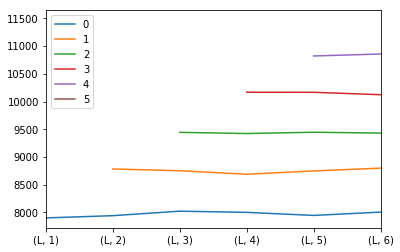

In [192]:
df_machine_reduction.iloc[:6,:].plot()

In [167]:
df_comparison["L"] = df_machine_reduction.iloc[:6,:].mean(axis=1).values

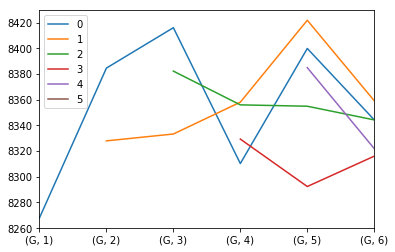

In [168]:
df_machine_reduction.iloc[6:12,:].plot()

In [169]:
df_comparison["G"] = df_machine_reduction.iloc[6:12,:].mean(axis=1).values

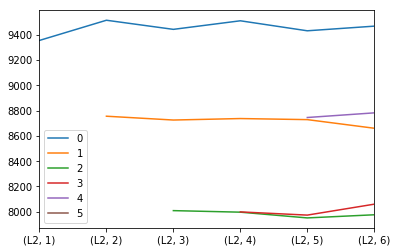

In [170]:
df_machine_reduction.iloc[12:,:].plot()

In [171]:
df_comparison["L2"] = df_machine_reduction.iloc[12:,:].mean(axis=1).values

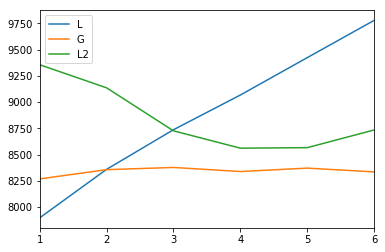

In [172]:
df_comparison = df_comparison.set_index(np.arange(1, 7))
df_comparison.plot()

Assumming 2 toolkits it's better to have "L" if we don't expend big colapse in demand, if we don it may be safer to considere "L2" option as it's not  much worse when 6 machines but when only one is working it's much more effective

In [188]:
df_machine_reduction.to_csv('results_machine_reduction.csv')
df_comparison.to_csv('results_comparison.csv')

In [189]:
pd.read_csv('results_machine_reduction.csv', index_col=0)

,0,1,2,3,4,5
"('L', 1)",7896.578624,NaN,NaN,NaN,NaN,NaN
"('L', 2)",7937.106369,8780.769996,NaN,NaN,NaN,NaN
"('L', 3)",8018.463667,8748.651734,9442.858374,NaN,NaN,NaN
"('L', 4)",7996.698489,8685.854459,9421.135152,10167.096533,NaN,NaN
"('L', 5)",7941.768346,8745.160529,9444.909662,10166.348052,10822.364700,NaN
"('L', 6)",8001.949217,8796.153309,9429.426298,10122.496239,10858.200383,11468.167359
"('G', 1)",8267.980806,NaN,NaN,NaN,NaN,NaN
"('G', 2)",8384.636667,8327.969733,NaN,NaN,NaN,NaN
"('G', 3)",8416.076308,8333.309301,8382.272591,NaN,NaN,NaN
"('G', 4)",8310.311043,8358.089111,8356.001934,8329.351330,NaN,NaN
